#### Imports

In [1]:
import pandas as pd 
import numpy as np

from env import username, password, get_db_url
import os

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

# import wrangle (create wrangle file for acquire and prep to use on final notebook)

# Wrangle Phase

In [2]:
def new_zillow_data():
    """
    This function will:
    - create a connect_url to mySQL
    - return a df of the given query from the zillow db
    """
    url = get_db_url('zillow')
    SQL_query = '''
                select bedroomcnt as bedrooms, bathroomcnt as bathrooms, calculatedfinishedsquarefeet as sqft
                    , taxvaluedollarcnt as property_value, yearbuilt as year_built, fips as county
                from properties_2017
                join predictions_2017 using(parcelid)
                where propertylandusetypeid = 261
                '''
    return pd.read_sql(SQL_query, url)

In [3]:
def get_zillow_data(filename="zillow.csv"):
    """
    This function will:
    - Check local directory for csv file
        - return if exists
    - If csv doesn't exists:
        - create a df of the SQL_query
        - write df to csv
    - Output zillow df
    """
    if os.path.exists(filename):
        df = pd.read_csv(filename, index_col=0) 
        print('Found CSV')
        return df
    
    else:
        df = new_zillow_data()
        
        #want to save to csv
        df.to_csv(filename)
        print('Creating CSV')
        return df

In [4]:
df = get_zillow_data()

Found CSV


In [5]:
df.shape

(52442, 6)

In [6]:
df.head()

,bedrooms,bathrooms,sqft,property_value,year_built,county
0,4.0,3.5,3100.0,1023282.0,1998.0,6059.0
1,2.0,1.0,1465.0,464000.0,1967.0,6111.0
2,3.0,2.0,1243.0,564778.0,1962.0,6059.0
3,4.0,3.0,2376.0,145143.0,1970.0,6037.0
4,4.0,3.0,2962.0,773303.0,1950.0,6037.0


In [7]:
df.isnull().sum()

bedrooms            0
bathrooms           0
sqft               82
property_value      1
year_built        116
county              0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bedrooms        52442 non-null  float64
 1   bathrooms       52442 non-null  float64
 2   sqft            52360 non-null  float64
 3   property_value  52441 non-null  float64
 4   year_built      52326 non-null  float64
 5   county          52442 non-null  float64
dtypes: float64(6)
memory usage: 2.8 MB


In [9]:
df.bedrooms.value_counts().sort_index()

0.0       137
1.0       612
2.0      8340
3.0     23360
4.0     15240
5.0      3973
6.0       635
7.0       106
8.0        24
9.0         8
10.0        2
11.0        1
12.0        3
14.0        1
Name: bedrooms, dtype: int64

In [10]:
df.bathrooms.value_counts().sort_index()

0.0       121
1.0      9568
1.5       841
2.0     21894
2.5      3934
3.0     10673
3.5       918
4.0      2227
4.5       687
5.0       803
5.5       224
6.0       322
6.5        47
7.0        88
7.5        16
8.0        53
8.5         3
9.0        13
10.0        5
11.0        3
13.0        1
18.0        1
Name: bathrooms, dtype: int64

In [11]:
df.county.value_counts()

6037.0    33911
6059.0    14136
6111.0     4395
Name: county, dtype: int64

In [ ]:
df.county = df.county.map({6037:'LA', 6059:'orange', 6111:'ventura'})

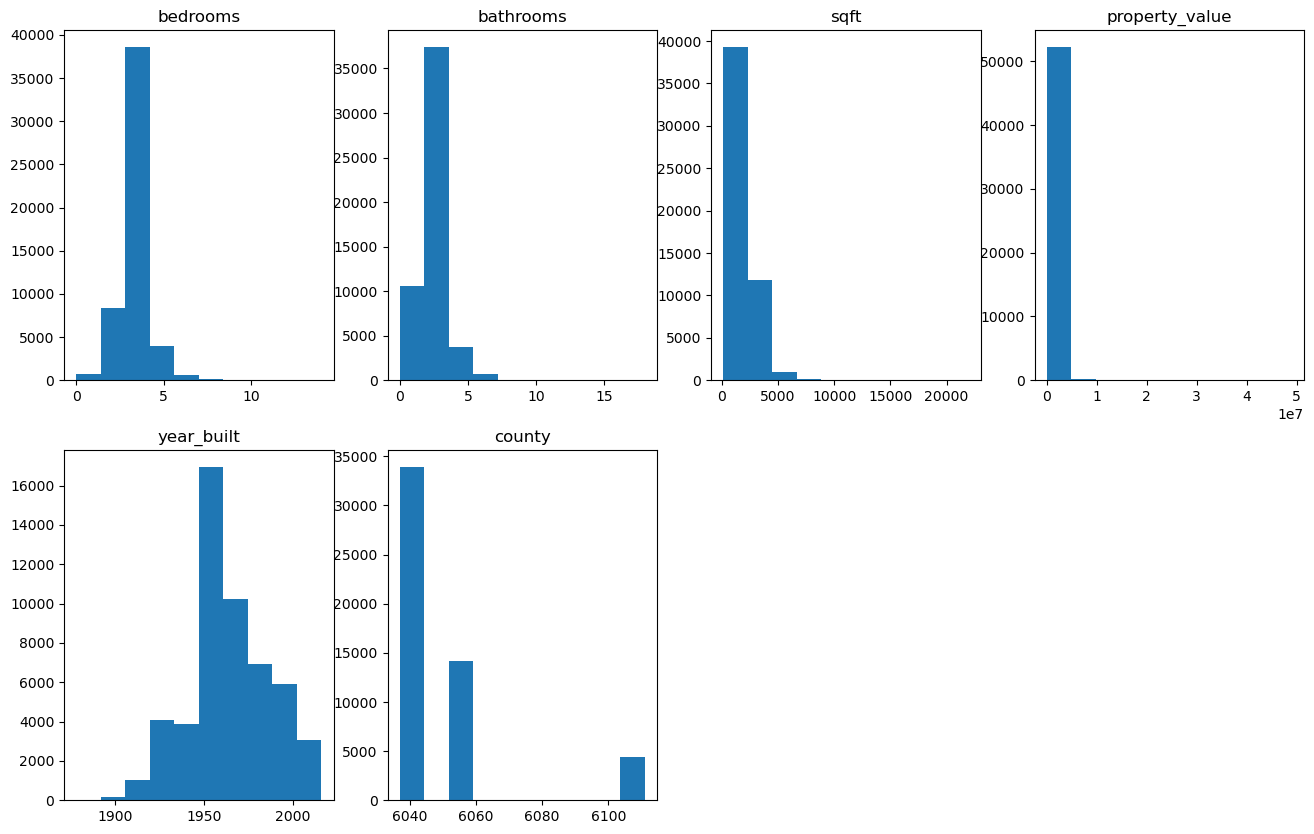

In [12]:
plt.figure(figsize=(16,10))

for i, col in enumerate(df.columns):
    
    plot_number = i + 1
    plt.subplot(2,4, plot_number)
    plt.title(col)
    plt.hist(df[col])
plt.show()

bedrooms


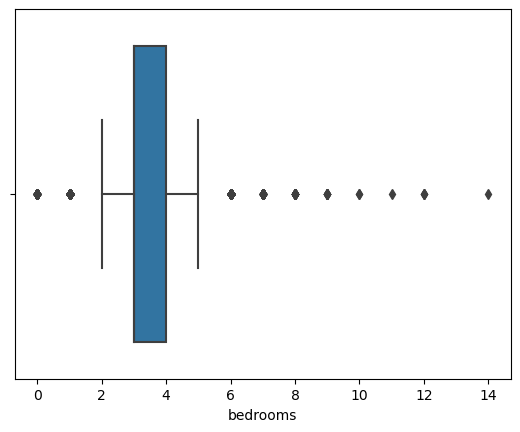

0.0       137
1.0       612
2.0      8340
3.0     23360
4.0     15240
5.0      3973
6.0       635
7.0       106
8.0        24
9.0         8
10.0        2
11.0        1
12.0        3
14.0        1
Name: bedrooms, dtype: int64

bathrooms


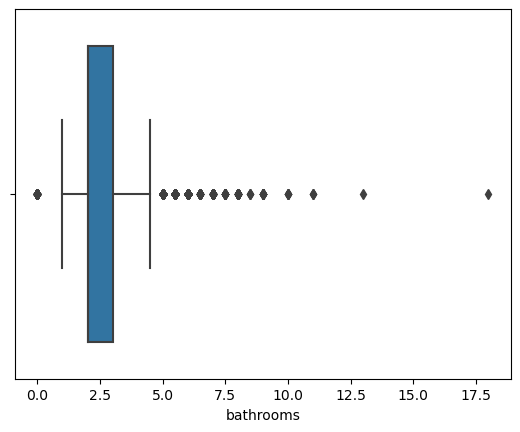

0.0       121
1.0      9568
1.5       841
2.0     21894
2.5      3934
3.0     10673
3.5       918
4.0      2227
4.5       687
5.0       803
5.5       224
6.0       322
6.5        47
7.0        88
7.5        16
8.0        53
8.5         3
9.0        13
10.0        5
11.0        3
13.0        1
18.0        1
Name: bathrooms, dtype: int64

sqft


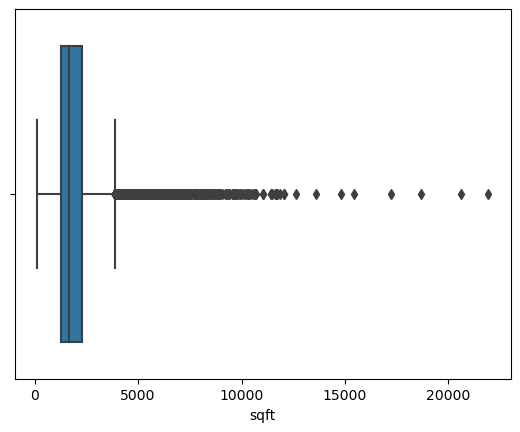

128.0      1
152.0      1
240.0      1
280.0      1
288.0      1
          ..
15450.0    1
17245.0    1
18654.0    1
20612.0    1
21929.0    1
Name: sqft, Length: 4723, dtype: int64

property_value


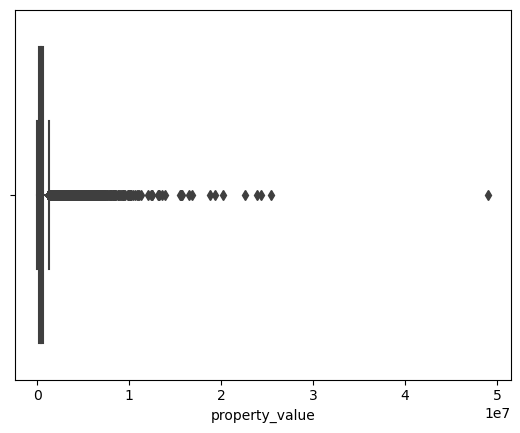

1000.0        1
3254.0        1
7771.0        1
9242.0        1
10504.0       1
             ..
22589311.0    1
23858374.0    1
24345695.0    1
25381250.0    1
49061236.0    1
Name: property_value, Length: 38942, dtype: int64

year_built


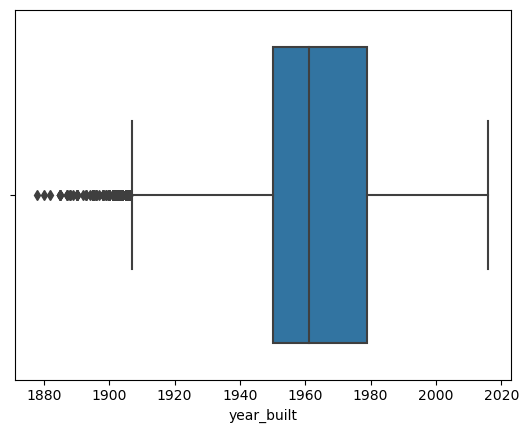

1878.0      1
1880.0      1
1882.0      1
1885.0      5
1887.0      3
         ... 
2012.0    112
2013.0    153
2014.0    165
2015.0     80
2016.0      3
Name: year_built, Length: 133, dtype: int64



In [13]:
for col in df.columns[:-1]:
    print(col)
    sns.boxplot(data=df, x=col)
    plt.show()
    
    print(df[col].value_counts().sort_index())
    print()

In [14]:
df.property_value.max()

49061236.0

In [15]:
df[df.property_value > 2_500_000]

,bedrooms,bathrooms,sqft,property_value,year_built,county
45,5.0,6.5,9586.0,3624442.0,1992.0,6059.0
214,3.0,2.0,1956.0,2715793.0,1927.0,6037.0
226,6.0,5.0,6249.0,3681324.0,1924.0,6037.0
319,8.0,9.0,8837.0,3350689.0,1951.0,6037.0
326,4.0,3.0,2966.0,2537058.0,1930.0,6037.0
...,...,...,...,...,...,...
52137,5.0,4.0,4580.0,3132251.0,1937.0,6037.0
52140,5.0,5.0,4472.0,2653980.0,1999.0,6037.0
52224,5.0,6.0,5945.0,2912659.0,2012.0,6037.0
52262,3.0,2.0,1376.0,3350325.0,1923.0,6037.0


In [16]:
df[df.property_value > 4_000_000]

,bedrooms,bathrooms,sqft,property_value,year_built,county
392,7.0,8.0,5906.0,6620375.0,1952.0,6037.0
486,4.0,4.5,3991.0,6689970.0,1998.0,6059.0
590,0.0,5.0,5782.0,4626995.0,2006.0,6037.0
747,4.0,5.0,4613.0,5177775.0,2010.0,6059.0
876,5.0,6.0,9311.0,5368861.0,2004.0,6111.0
...,...,...,...,...,...,...
51858,5.0,6.0,7520.0,6111576.0,1931.0,6037.0
52077,6.0,9.0,10525.0,15736374.0,1992.0,6037.0
52085,6.0,8.0,9406.0,5983100.0,2007.0,6037.0
52124,3.0,6.0,4230.0,10050974.0,1969.0,6037.0


In [17]:
df[df.property_value > 100_000]

,bedrooms,bathrooms,sqft,property_value,year_built,county
0,4.0,3.5,3100.0,1023282.0,1998.0,6059.0
1,2.0,1.0,1465.0,464000.0,1967.0,6111.0
2,3.0,2.0,1243.0,564778.0,1962.0,6059.0
3,4.0,3.0,2376.0,145143.0,1970.0,6037.0
4,4.0,3.0,2962.0,773303.0,1950.0,6037.0
...,...,...,...,...,...,...
52434,4.0,3.0,2068.0,332251.0,1967.0,6037.0
52436,4.0,2.0,1633.0,346534.0,1962.0,6037.0
52437,2.0,2.0,1286.0,354621.0,1940.0,6037.0
52440,3.0,2.0,1762.0,522000.0,1955.0,6037.0


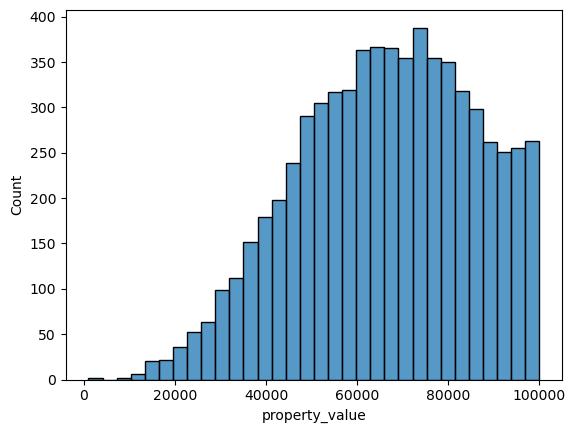

In [18]:
sns.histplot(df[df.property_value < 100_000].property_value)
plt.show()

<AxesSubplot:xlabel='property_value', ylabel='Count'>

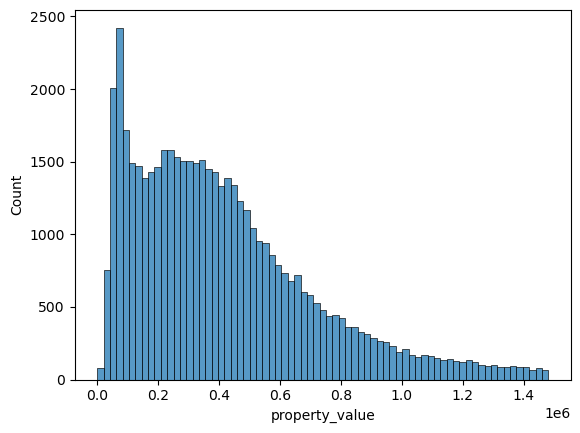

In [19]:
sns.histplot(df [df.property_value < df.property_value.quantile(.95)].property_value)

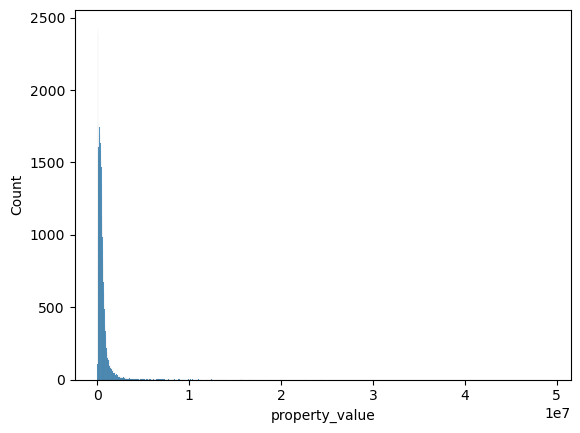

In [20]:
sns.histplot(df.property_value)
plt.show()

In [21]:
df[df.sqft <= df.sqft.mean() + (3 * df.sqft.std())]

,bedrooms,bathrooms,sqft,property_value,year_built,county
0,4.0,3.5,3100.0,1023282.0,1998.0,6059.0
1,2.0,1.0,1465.0,464000.0,1967.0,6111.0
2,3.0,2.0,1243.0,564778.0,1962.0,6059.0
3,4.0,3.0,2376.0,145143.0,1970.0,6037.0
4,4.0,3.0,2962.0,773303.0,1950.0,6037.0
...,...,...,...,...,...,...
52437,2.0,2.0,1286.0,354621.0,1940.0,6037.0
52438,4.0,2.0,1612.0,67205.0,1964.0,6111.0
52439,3.0,1.0,1032.0,49546.0,1954.0,6037.0
52440,3.0,2.0,1762.0,522000.0,1955.0,6037.0


In [22]:
def wrangle_zillow(df):
    '''
    This function is:
    - Dropping nulls
    - Changing dtype to int for bedrooms, sqft, tax_value, year_built
    - Assigning county names
    - Handling outliers for:
         bedrooms, bathrooms, sqft, property_value
    '''
    
    df = df.copy()
    df = df.dropna()
    
    make_ints = ['bedrooms', 'sqft', 'property_value', 'year_built']

    for col in make_ints:
        df[col] = df[col].astype(int)
        
    df.county = df.county.map({6037:'la', 6059:'orange', 6111:'ventura'})
    
    df = df[df.bedrooms.between(1,7)]
    df = df[df.bathrooms.between(1,6)]
    df = df[df.sqft <= df.sqft.mean() + (3 * df.sqft.std())]
    df = df[df.sqft >= 500]
    df = df[df.property_value < df.property_value.quantile(.95)]
    df = df[df.property_value > 100_000]
    
    return df

In [23]:
df = wrangle_zillow(df)

In [24]:
df.shape

(41986, 6)

In [150]:
52442 - df.shape[0]

10456

In [148]:
df.shape[0] / 52442

0.8006178254071165

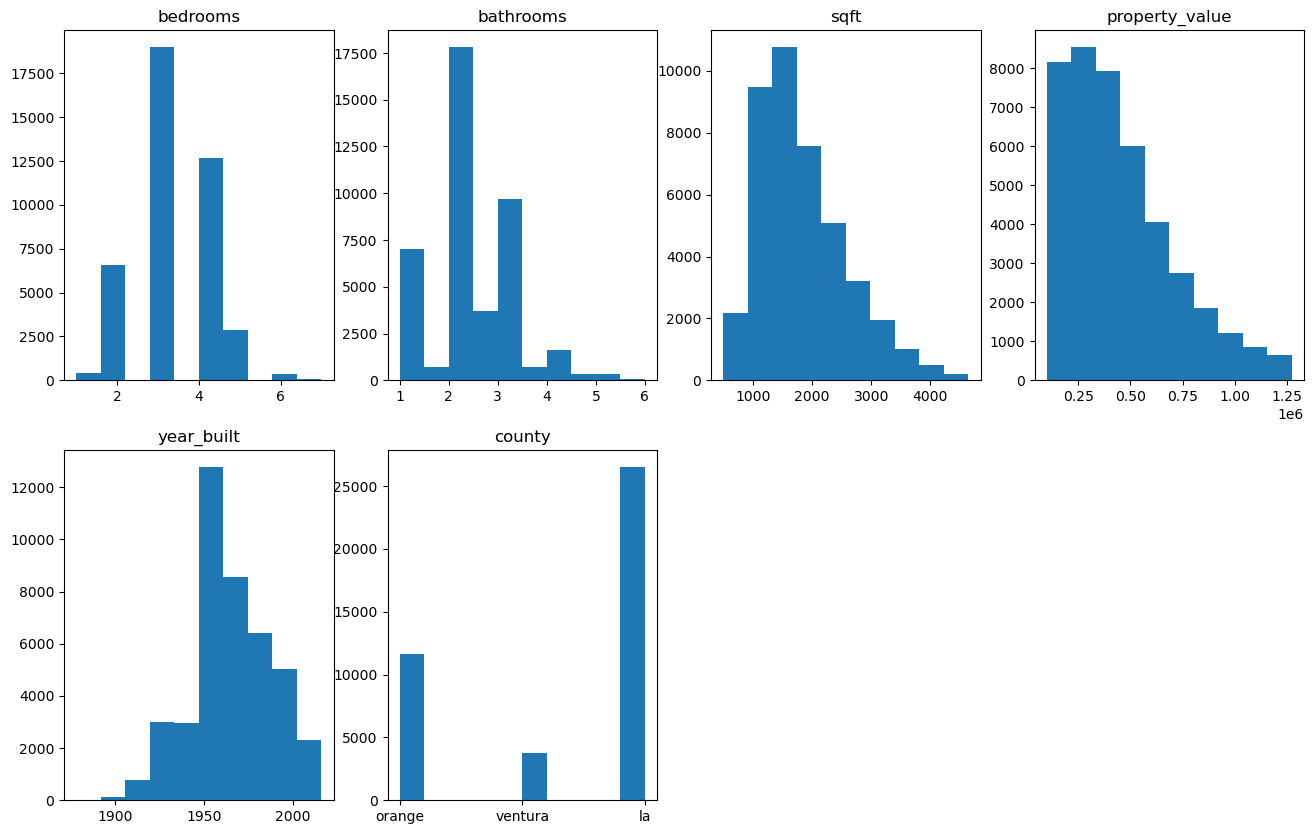

In [26]:
plt.figure(figsize=(16,10))

for i, col in enumerate(df.columns):
    
    plot_number = i + 1
    plt.subplot(2,4, plot_number)
    plt.title(col)
    plt.hist(df[col])
plt.show()

bedrooms


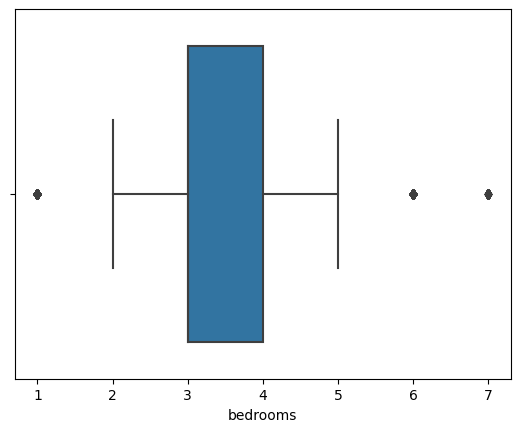

1      396
2     6571
3    19001
4    12697
5     2890
6      375
7       56
Name: bedrooms, dtype: int64

bathrooms


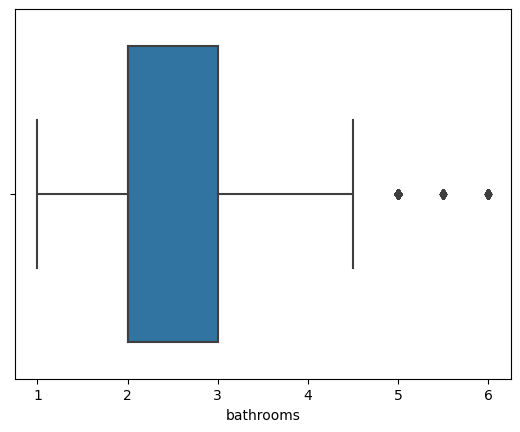

1.0     7013
1.5      703
2.0    17823
2.5     3711
3.0     9683
3.5      692
4.0     1596
4.5      362
5.0      331
5.5       30
6.0       42
Name: bathrooms, dtype: int64

sqft


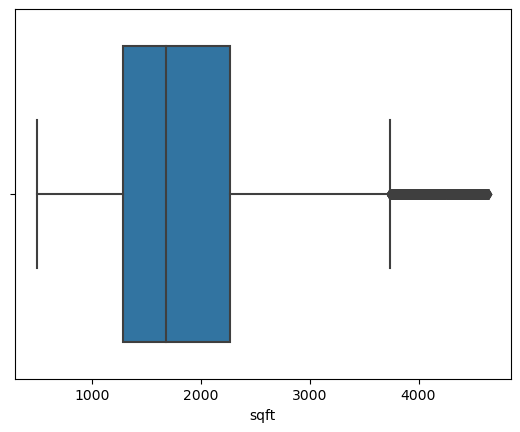

500     1
501     1
504     2
512     1
516     1
       ..
4631    1
4632    1
4638    1
4640    1
4641    2
Name: sqft, Length: 3591, dtype: int64

property_value


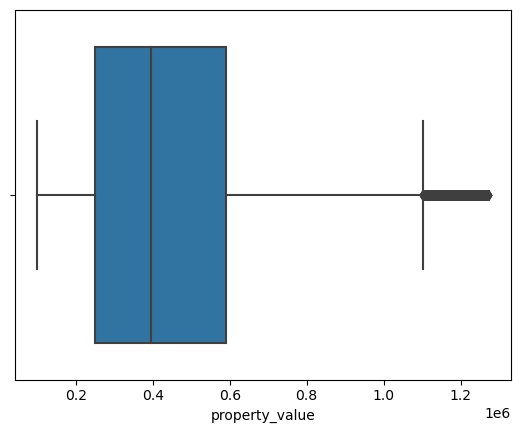

100002     1
100038     1
100058     1
100063     1
100073     1
          ..
1271653    1
1271654    2
1271904    1
1272000    1
1272184    1
Name: property_value, Length: 30182, dtype: int64

year_built


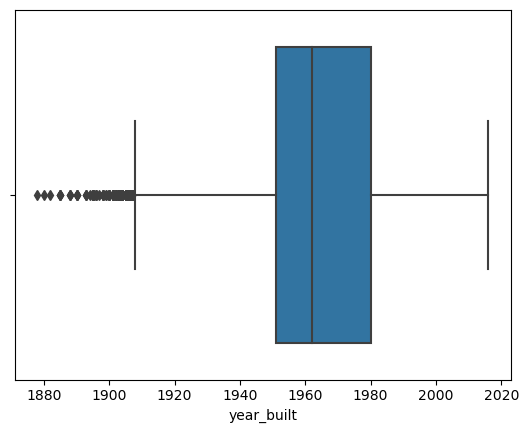

1878      1
1880      1
1882      1
1885      4
1888      3
       ... 
2012     77
2013    107
2014    126
2015     59
2016      1
Name: year_built, Length: 130, dtype: int64



In [27]:
for col in df.columns[:-1]:
    print(col)
    sns.boxplot(data=df, x=col)
    plt.show()
    
    print(df[col].value_counts().sort_index())
    print()

In [28]:
df.bathrooms.mean()

2.251869670842662

In [29]:
df.bedrooms.mean()

3.2968370409184016

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41986 entries, 0 to 52441
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bedrooms        41986 non-null  int64  
 1   bathrooms       41986 non-null  float64
 2   sqft            41986 non-null  int64  
 3   property_value  41986 non-null  int64  
 4   year_built      41986 non-null  int64  
 5   county          41986 non-null  object 
dtypes: float64(1), int64(4), object(1)
memory usage: 2.2+ MB


In [32]:
df.describe()

,bedrooms,bathrooms,sqft,property_value,year_built
count,41986.000000,41986.000000,41986.000000,4.198600e+04,41986.000000
mean,3.296837,2.251870,1842.784547,4.482627e+05,1964.468251
std,0.886342,0.836211,739.274833,2.566293e+05,22.827465
min,1.000000,1.000000,500.000000,1.000020e+05,1878.000000
25%,3.000000,2.000000,1288.000000,2.487360e+05,1951.000000
50%,3.000000,2.000000,1680.000000,3.957925e+05,1962.000000
75%,4.000000,3.000000,2267.000000,5.900000e+05,1980.000000
max,7.000000,6.000000,4641.000000,1.272184e+06,2016.000000


In [37]:
# This function will create dummy variable columns

def create_dummy_variables(df, dummy_cols):
    '''
    inputs:
    df , variable with list of strings or single string
    output:
    df with dummy columns
    '''
    dummy_df = pd.get_dummies(df[dummy_cols], drop_first=True)
    df = pd.concat([df, dummy_df], axis=1)
    return df

In [38]:
dummy_cols = 'county'

In [39]:
df = create_dummy_variables(df, dummy_cols)

In [40]:
df.head()

,bedrooms,bathrooms,sqft,property_value,year_built,county,orange,ventura
0,4,3.5,3100,1023282,1998,orange,1,0
1,2,1.0,1465,464000,1967,ventura,0,1
2,3,2.0,1243,564778,1962,orange,1,0
3,4,3.0,2376,145143,1970,la,0,0
4,4,3.0,2962,773303,1950,la,0,0


In [33]:
#SPLIT FUNCTION

def split_function(df):
    '''
    Take in a data frame and returns:
    train, validate, test 
    subset data frames
    '''
    train, test = train_test_split(df,
                              test_size=0.20,
                              random_state=123,
                                  )
    train, validate = train_test_split(train,
                                  test_size=.25,
                                  random_state=123,
                                      )
    return train, validate, test

In [41]:
train, validate, test = split_function(df)

In [42]:
print(f'      df:', df.shape)
print(f'   train:', train.shape)
print(f'validate:', validate.shape)
print(f'    test:', test.shape)

      df: (41986, 8)
   train: (25191, 8)
validate: (8397, 8)
    test: (8398, 8)


In [43]:
train.head()

,bedrooms,bathrooms,sqft,property_value,year_built,county,orange,ventura
26647,3,2.0,1304,195567,1950,la,0,0
45179,3,2.0,1312,210773,1979,la,0,0
30791,4,2.0,2768,551322,1951,la,0,0
44534,4,2.0,1888,332147,1955,la,0,0
37811,3,2.0,1812,377866,1973,orange,1,0


## Takeaways

* Original data set (52_442)
* Dropped 199 nulls
* I defined single family residence as the following:
    * At least:
        * 1 Bedroom
        * 1 Bathroom
* Handled outliers:
    * Dropped 8+ bedroom homes
    * Dropped 7+ bathroom homes
    * Dropped sqft below 500 and 3 standard deviations above the mean sqft
    * Dropped property_value less than 100_000 and greater than .95 quantile
* Dropped 10_456 rows of data
* 80% of the original data is remaining
* Mapped county to county code
* Created dummy columns for ML model
* Split into train, validate, test
* Copy paste 5 functions to wrangle.py file:
    * new_zillow_data()
    * get_zillow_data()
    * wrangle_zillow()
    * create_dummy_variables()
    * split_function()

# Explore

In [44]:
train.head()

,bedrooms,bathrooms,sqft,property_value,year_built,county,orange,ventura
26647,3,2.0,1304,195567,1950,la,0,0
45179,3,2.0,1312,210773,1979,la,0,0
30791,4,2.0,2768,551322,1951,la,0,0
44534,4,2.0,1888,332147,1955,la,0,0
37811,3,2.0,1812,377866,1973,orange,1,0


In [45]:
train.describe()

,bedrooms,bathrooms,sqft,property_value,year_built,orange,ventura
count,25191.000000,25191.000000,25191.000000,2.519100e+04,25191.000000,25191.000000,25191.000000
mean,3.294629,2.247708,1838.826883,4.476163e+05,1964.348617,0.277162,0.089278
std,0.883245,0.829316,734.063978,2.553718e+05,22.728171,0.447606,0.285150
min,1.000000,1.000000,500.000000,1.000730e+05,1880.000000,0.000000,0.000000
25%,3.000000,2.000000,1288.000000,2.489380e+05,1951.000000,0.000000,0.000000
50%,3.000000,2.000000,1678.000000,3.959460e+05,1962.000000,0.000000,0.000000
75%,4.000000,3.000000,2258.000000,5.885070e+05,1980.000000,1.000000,0.000000
max,7.000000,6.000000,4641.000000,1.272184e+06,2015.000000,1.000000,1.000000


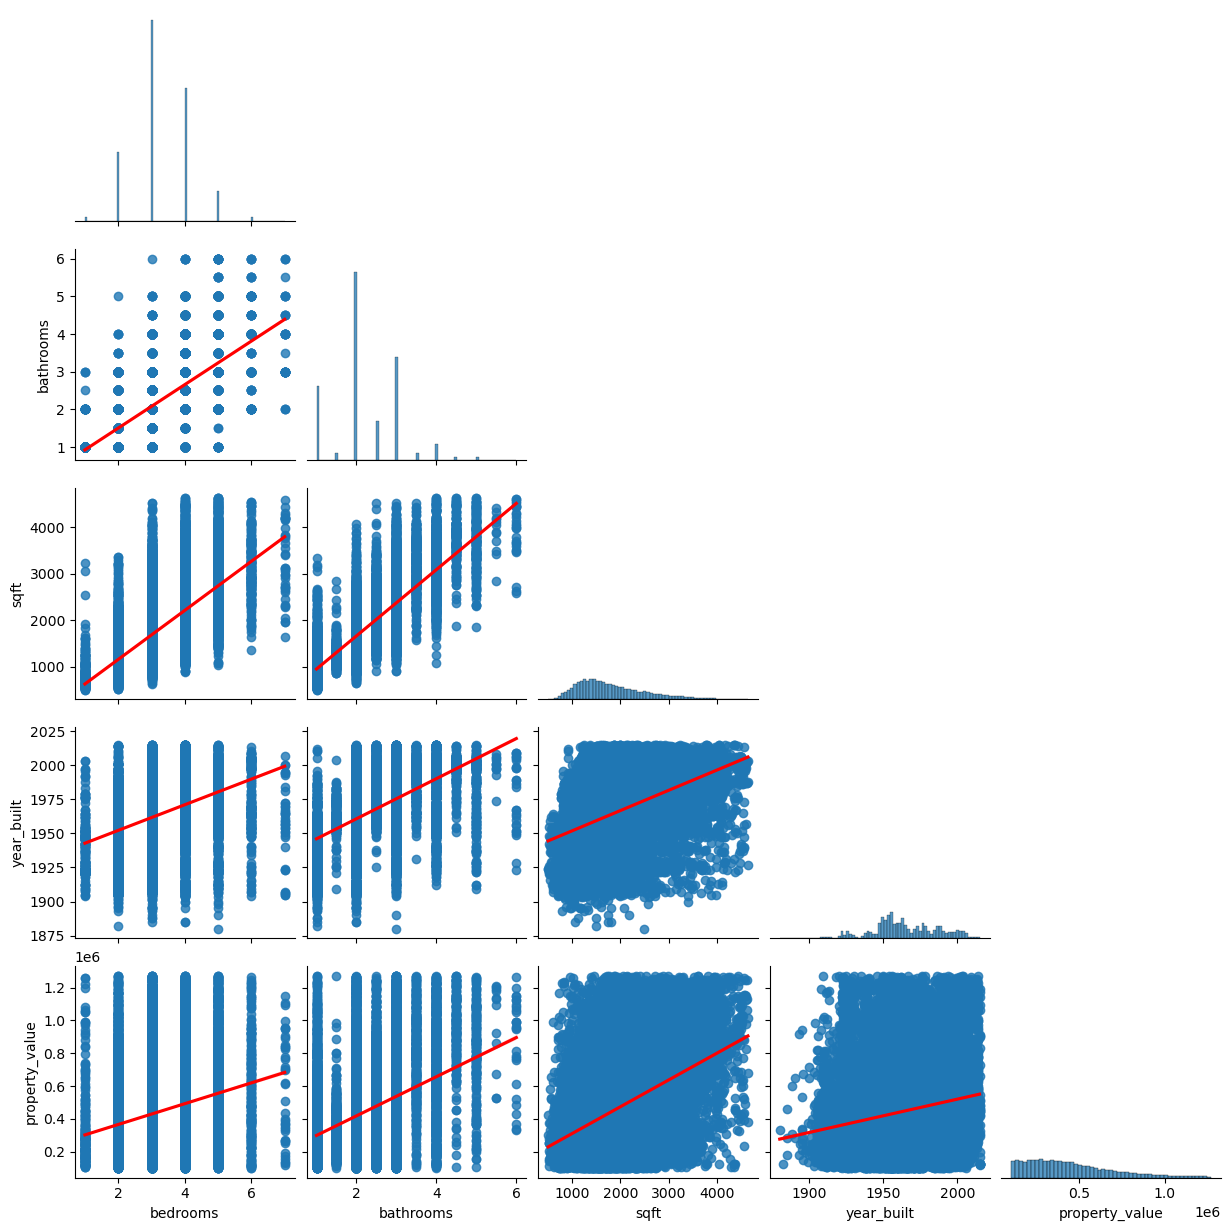

In [52]:
# create a list of column names, with the target variable 'property_value' at the end
cols = list(train.columns)
cols.remove('property_value')
cols.append('property_value')

# create the pair plot with the reordered columns
sns.pairplot(train[cols].drop(columns=['county', 'orange', 'ventura']), kind='reg', plot_kws={'line_kws':{'color':'red'}}, corner=True)
plt.show()

In [53]:
def plot_variable_pairs(train):
    '''
    Insert train dataframe
    
    '''
    # isolating columns I want to plot with target variable
    columns_to_plot = ['bedrooms', 'bathrooms', 'sqft', 'year_built']
    
    # created a for loop to plot variable with target variable including regression line
    for col in columns_to_plot:
        sns.regplot(x=col, y='property_value', data=train, line_kws = {'color':'red'})
        plt.title(f'{col} vs. tax value')
        plt.show()

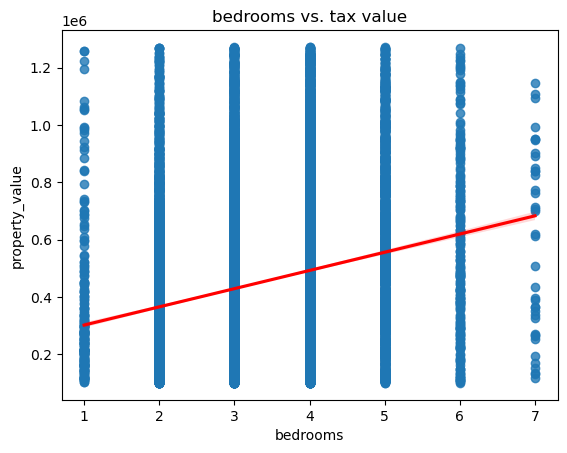

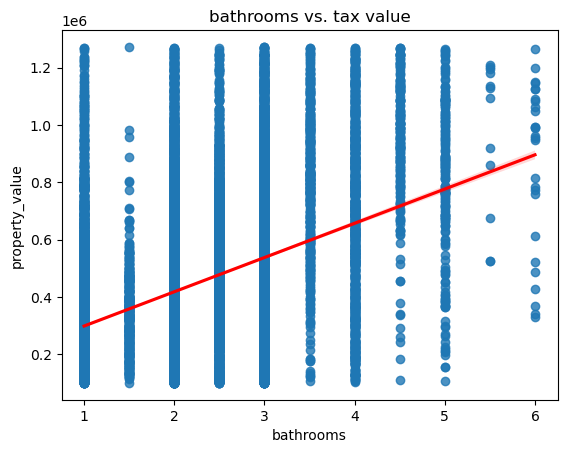

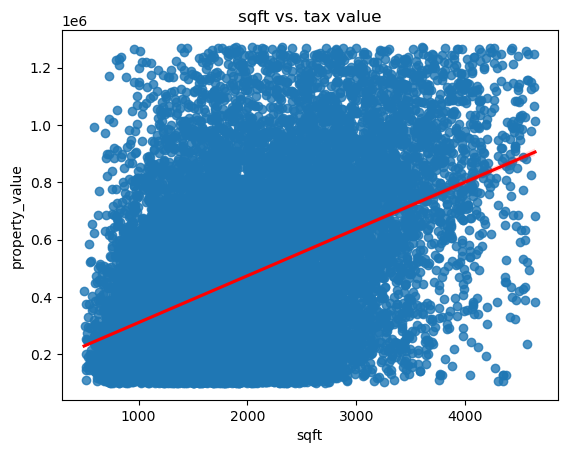

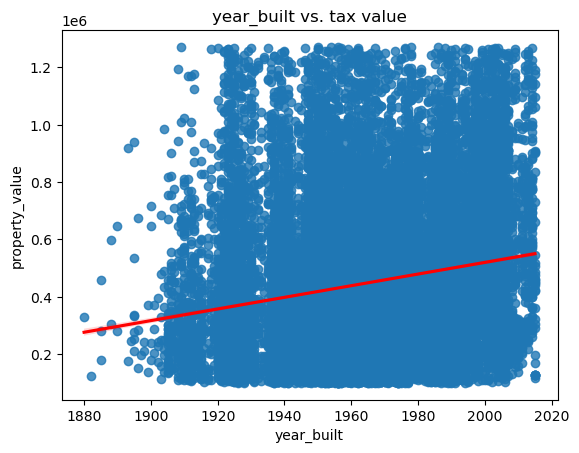

In [54]:
plot_variable_pairs(train)

In [55]:
def plot_categorical_and_continuous_vars(train, cont, cat):
    '''
    input cont and cat variables as strings
    i.e. 'bedrooms', 'sqft'
    '''
    cont_var= cont
    cat_var = cat
    
    # create a figure with 2 rows and 3 columns of subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
    
    # plot data on each subplot
    sns.jointplot(x=cont_var, y='property_value', data=train, kind='scatter', ax=axes[0, 0])
    sns.regplot(x=cont_var, y='property_value', data=train, line_kws = {'color':'red'}, ax=axes[0, 1])
    sns.scatterplot(x=cont_var, y='property_value', data=train, ax=axes[0, 2])
    
    sns.barplot(x=cat_var, y='property_value', data=train, ax=axes[1, 0])
    sns.violinplot(x=cat_var, y='property_value', data=train, ax=axes[1, 1])
    sns.boxplot(x=cat_var, y='property_value', data=train, ax=axes[1, 2])
    
    plt.tight_layout()
    plt.show()

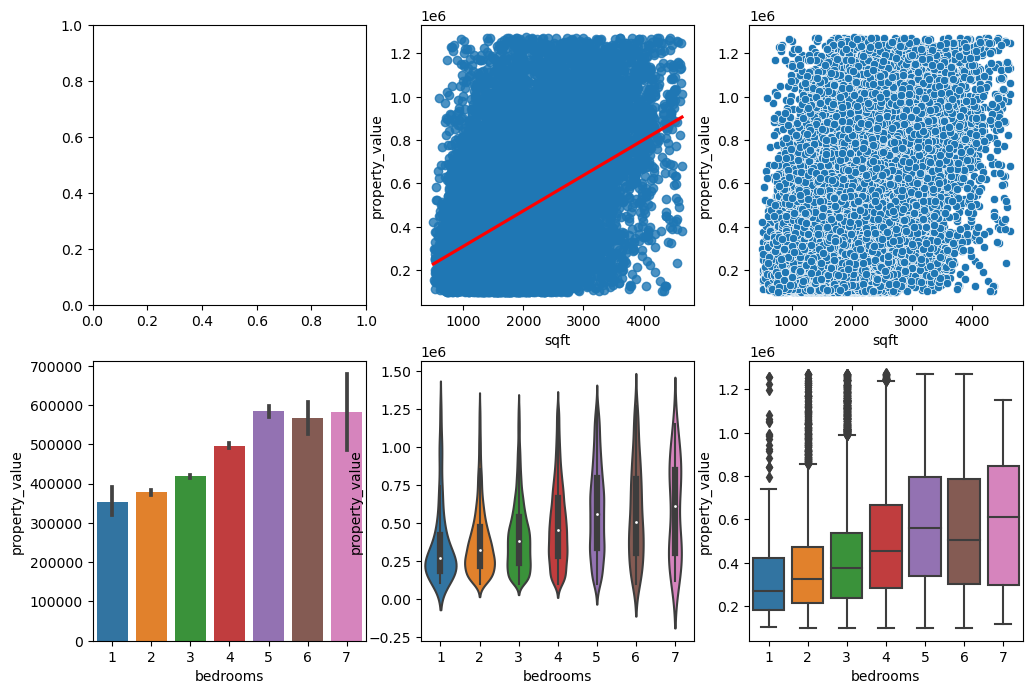

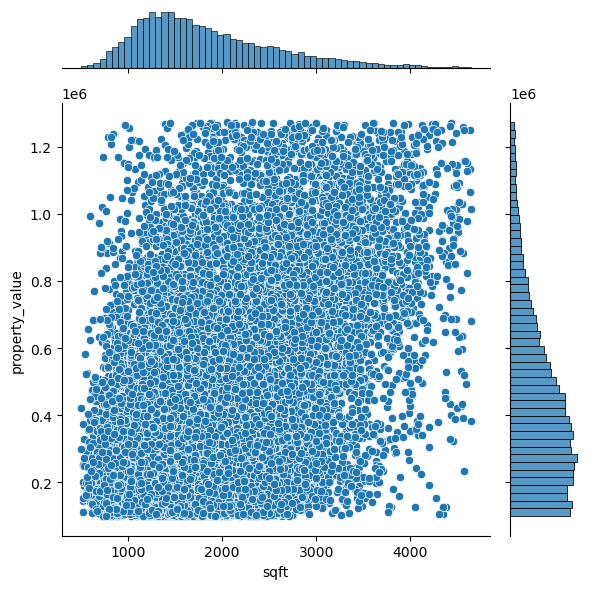

In [57]:
plot_categorical_and_continuous_vars(train, 'sqft', 'bedrooms')

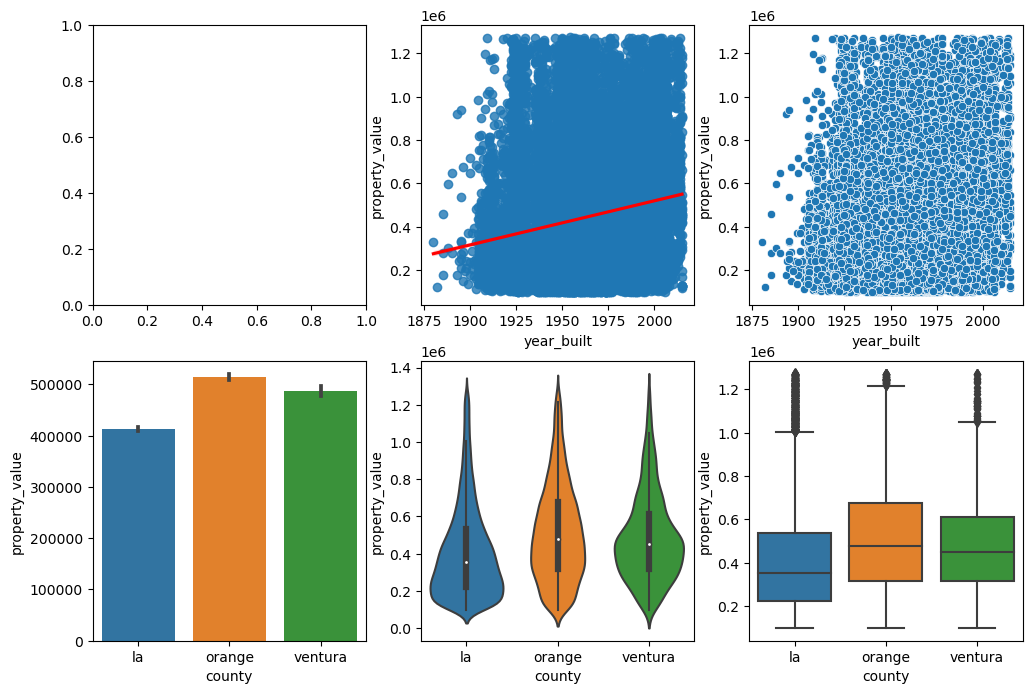

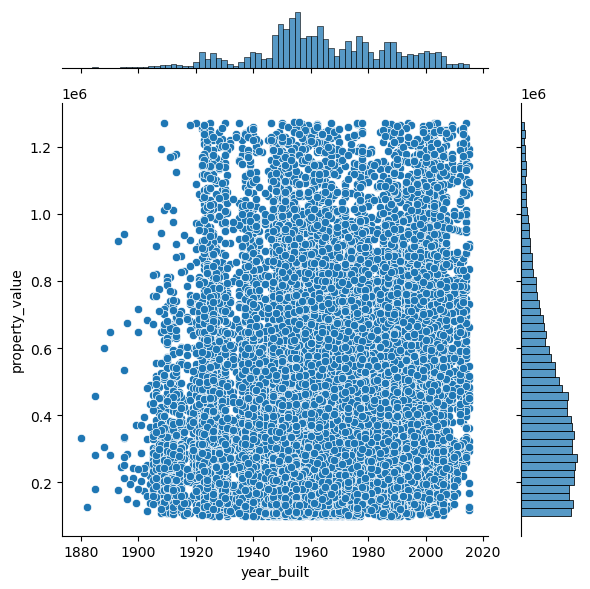

In [58]:
plot_categorical_and_continuous_vars(train, 'year_built', 'county')

In [60]:
feature_corr = train.corr(method='spearman')
feature_corr

,bedrooms,bathrooms,sqft,property_value,year_built,orange,ventura
bedrooms,1.000000,0.608573,0.652559,0.212277,0.403393,0.099250,0.100308
bathrooms,0.608573,1.000000,0.816693,0.347731,0.578540,0.154833,0.069166
sqft,0.652559,0.816693,1.000000,0.404679,0.518439,0.144899,0.084399
property_value,0.212277,0.347731,0.404679,1.000000,0.177743,0.173880,0.068476
year_built,0.403393,0.578540,0.518439,0.177743,1.000000,0.306714,0.184563
orange,0.099250,0.154833,0.144899,0.173880,0.306714,1.000000,-0.193877
ventura,0.100308,0.069166,0.084399,0.068476,0.184563,-0.193877,1.000000


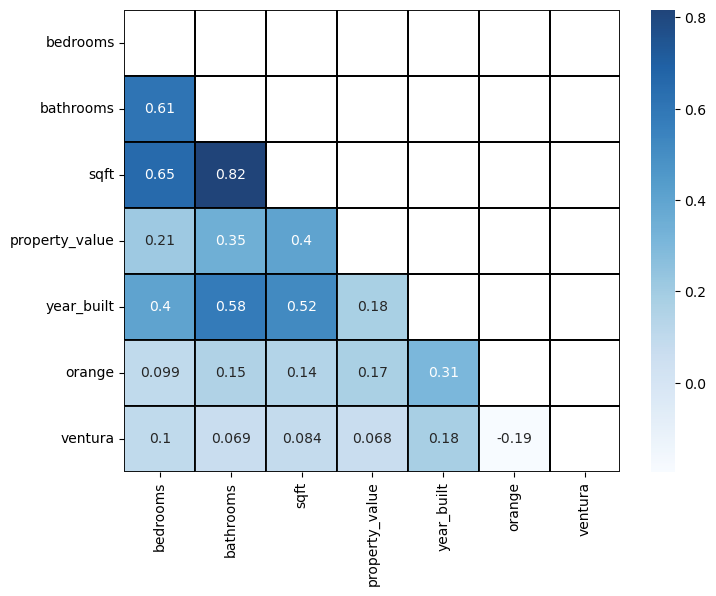

In [61]:
kwargs= {'alpha':.9, 'linewidth':.3, 'linestyle':'-',
        'linecolor':'k', 'rasterized':False, 'edgecolor':'w',
        'capstyle':'projecting',}

plt.figure(figsize=(8,6))
sns.heatmap(feature_corr, cmap='Blues', annot=True, mask = np.triu(feature_corr), **kwargs)


plt.show()

### Hypothesis 1

$H_0$: There is no linear relationship between bathrooms and sqft

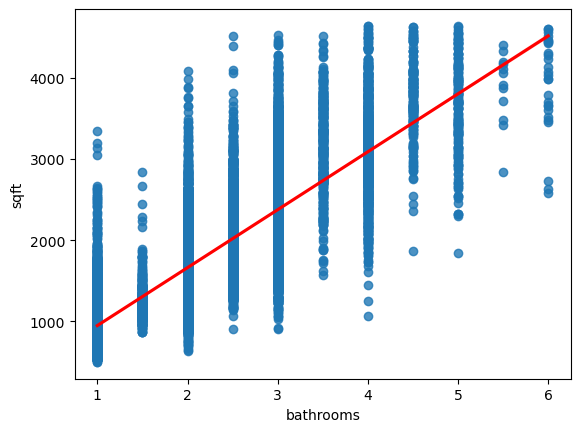

In [62]:
sns.regplot(data=train, x='bathrooms', y='sqft', line_kws={'color':'red'})
plt.show()

In [63]:
alpha = 0.05

r, p = stats.spearmanr(train.bathrooms, train.sqft)
print('r =', r)
print('p =', p)

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

r = 0.8166932859154683
p = 0.0
We reject the null hypothesis


In [ ]:
def bath_sqft_relationship(train):
    sns.regplot(data=train, x='bathrooms', y='sqft', line_kws={'color':'red'})
    plt.show()
    
    alpha = 0.05
    
    r, p = stats.spearmanr(train.bathrooms, train.sqft)
    print('r =', r)
    print('p =', p)
    
    if p < alpha:
        print("There is a relationship between the number of bathrooms and the square footage of a single family property")
    else:
        print("There is not a relationship between the number of bathrooms and the square footage of a single family property")

There is a relationship between the number of bathrooms and the sqft of a single family residence

### Hypothesis 2

$H_0$: There is no relationship between sqft and property_value

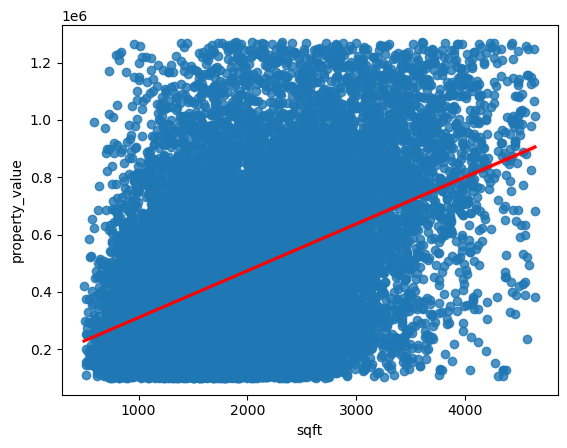

In [65]:
sns.regplot(data=train, x='sqft', y='property_value', line_kws={'color':'red'})
plt.show()

In [64]:
alpha = 0.05

r, p = stats.spearmanr(train.sqft, train.property_value)
print('r =', r)
print('p =', p)

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

r = 0.40467921112300553
p = 0.0
We reject the null hypothesis


There is a relationship between sqft and property_value of a single family residence

### Hypothesis 3

$H_0$: There is no linear relationship between bathrooms and property_value

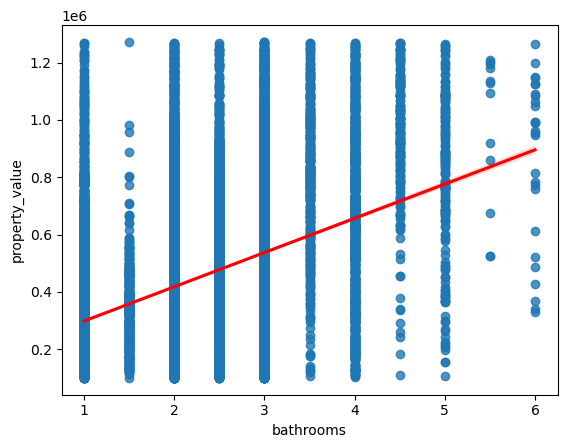

In [66]:
sns.regplot(data=train, x='bathrooms', y='property_value', line_kws={'color':'red'})
plt.show()

In [67]:
alpha = 0.05

r, p = stats.spearmanr(train.bathrooms, train.property_value)
print('r =', r)
print('p =', p)

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

r = 0.3477310800774655
p = 0.0
We reject the null hypothesis


There is a relationship between the amount of bathrooms and property_value

### Hypothesis 4

$H_0$: There is no relationship between year_built and sqft

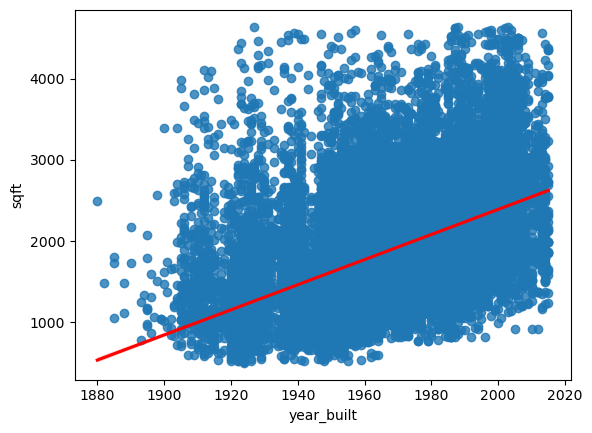

In [68]:
sns.regplot(data=train, x='year_built', y='sqft', line_kws={'color':'red'})
plt.show()

In [69]:
alpha = 0.05

r, p = stats.spearmanr(train.year_built, train.sqft)
print('r =', r)
print('p =', p)

if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

r = 0.5184390699385084
p = 0.0
We reject the null hypothesis


There is a relationship between year_built and sqft

# Scale data

In [70]:
def scale_data(train,
              validate,
              test,
              to_scale):
    '''
    create to_scale variable with a list of columns you want to scale
    returns:
    train_scaled, validate_scaled, test_scaled
    '''
    # make copies for scaling
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    # Make the thing
    scaler = MinMaxScaler()
    
    #fit the thing
    scaler.fit(train[to_scale])
    
    #use the thing
    train_scaled[to_scale] = scaler.transform(train[to_scale])
    validate_scaled[to_scale] = scaler.transform(validate[to_scale])
    test_scaled[to_scale] = scaler.transform(test[to_scale])
    
    return train_scaled, validate_scaled, test_scaled

In [71]:
train.head()

,bedrooms,bathrooms,sqft,property_value,year_built,county,orange,ventura
26647,3,2.0,1304,195567,1950,la,0,0
45179,3,2.0,1312,210773,1979,la,0,0
30791,4,2.0,2768,551322,1951,la,0,0
44534,4,2.0,1888,332147,1955,la,0,0
37811,3,2.0,1812,377866,1973,orange,1,0


In [72]:
to_scale = ['bedrooms', 'bathrooms', 'sqft', 'year_built']

In [73]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, to_scale)

In [74]:
train_scaled.head()

,bedrooms,bathrooms,sqft,property_value,year_built,county,orange,ventura
26647,0.333333,0.2,0.194156,195567,0.518519,la,0,0
45179,0.333333,0.2,0.196088,210773,0.733333,la,0,0
30791,0.500000,0.2,0.547694,551322,0.525926,la,0,0
44534,0.500000,0.2,0.335185,332147,0.555556,la,0,0
37811,0.333333,0.2,0.316832,377866,0.688889,orange,1,0


In [75]:
def Xy_train_val_test(train, validate, test, target_variable, drop_cols):
    """
    input train, validate, test, after using split function()
    input target_variable as string
    drop_cols formatted as: ['col1', 'col2', 'etc'] for multiple columns
        This function will drop all 'object' columns. Identify additional 
        columns you want to drop and insert 1 column as a string or multiple
        columns in a list of strings.
    returns:
    X_train, X_validate, X_test, y_train, y_validate, y_test
    """
    
    baseline_accuracy = train[target_variable].mean()
    print(f'Baseline Accuracy: {baseline_accuracy}')
    
    X_train = train.select_dtypes(exclude=['object']).drop(columns=[target_variable]).drop(columns=drop_cols)
    X_validate = validate.select_dtypes(exclude=['object']).drop(columns=[target_variable]).drop(columns=drop_cols)
    X_test = test.select_dtypes(exclude=['object']).drop(columns=[target_variable]).drop(columns=drop_cols)
    
    y_train = train[target_variable]
    y_validate = validate[target_variable]
    y_test = test[target_variable]
    
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [81]:
drop_cols = ['orange', 'ventura']

In [85]:
X_train, X_validate, X_test, y_train, y_validate, y_test = Xy_train_val_test(train_scaled, 
                                                                             validate_scaled, 
                                                                             test_scaled, 
                                                                             'property_value', 
                                                                             drop_cols)

Baseline Accuracy: 447616.3455996189


In [86]:
X_train.head()

,bedrooms,bathrooms,sqft,year_built
26647,0.333333,0.2,0.194156,0.518519
45179,0.333333,0.2,0.196088,0.733333
30791,0.500000,0.2,0.547694,0.525926
44534,0.500000,0.2,0.335185,0.555556
37811,0.333333,0.2,0.316832,0.688889


In [87]:
y_train[:5]

26647    195567
45179    210773
30791    551322
44534    332147
37811    377866
Name: property_value, dtype: int64

# Modeling

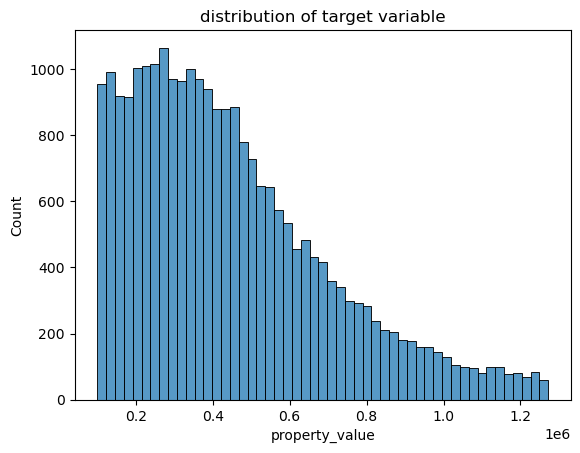

In [88]:
sns.histplot(y_train)
plt.title('distribution of target variable')
plt.show()

In [90]:
baseline = y_train.mean()
baseline

447616.3455996189

In [91]:
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [92]:
baseline_array = np.repeat(baseline, len(train))
baseline_array

array([447616.34559962, 447616.34559962, 447616.34559962, ...,
       447616.34559962, 447616.34559962, 447616.34559962])

In [93]:
rmse, r2 = metrics_reg(y_train, baseline_array)
rmse, r2

(255366.69400808454, 0.0)

In [94]:
metrics_df = pd.DataFrame(data=[
    {
        'model': 'baseline',
        'rmse': rmse,
        'r2': r2 
    }
])
metrics_df

,model,rmse,r2
0,baseline,255366.694008,0.0


#### Ordinary Least Squares (OLS)

In [95]:
# make it
lr1 = LinearRegression()

# fit it on our RFE features
lr1.fit(X_train, y_train)

# use it (make predictions)
pred_lr1 = lr1.predict(X_train)

# use it on validate
pred_validate_lr1 = lr1.predict(X_validate)

In [97]:
pred_lr1[:5]

array([367206.81314838, 347497.75850957, 587287.33986795, 426798.69020207,
       441401.7415463 ])

In [98]:
metrics_reg(y_train, pred_lr1)

(223263.4619551843, 0.23562442488666557)

In [99]:
rmse, r2 = metrics_reg(y_validate, pred_validate_lr1)
rmse, r2

(224701.24174211267, 0.24578213913996405)

In [104]:
metrics_df.loc[1] = ['ols', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,255366.694008,0.000000
2,ols,224701.241742,0.245782
1,ols,224701.241742,0.245782


#### LassoLars

In [106]:
from sklearn.linear_model import LassoLars

In [107]:
# make it
lars = LassoLars(alpha=1, normalize=False)

# fit it
lars.fit(X_train, y_train)

# use it
pred_lars = lars.predict(X_train)
pred_validate_lars = lars.predict(X_validate)

In [108]:
pd.Series(lars.coef_, index=lars.feature_names_in_)

bedrooms     -247876.111657
bathrooms     146899.576173
sqft          741421.781665
year_built    -98342.098411
dtype: float64

In [109]:
metrics_reg(y_train, pred_lars)

(223263.46275841078, 0.2356244193867354)

In [110]:
rmse, r2 = metrics_reg(y_validate, pred_validate_lars)
rmse, r2

(224701.21343643614, 0.24578232915801024)

In [111]:
metrics_df.loc[2] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,255366.694008,0.000000
2,lars,224701.213436,0.245782
1,ols,224701.241742,0.245782


#### Polynomial Regression

In [121]:
from sklearn.preprocessing import PolynomialFeatures

In [122]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

#### fit on a linear regression model

In [123]:
# make it
pr = LinearRegression()

# fit it
pr.fit(X_train_degree2, y_train)

# use it
pred_pr = pr.predict(X_train_degree2)
pred_validate_pr = pr.predict(X_validate_degree2)

In [124]:
metrics_reg(y_train, pred_pr)

(221964.71529321378, 0.24449146305558667)

In [125]:
rmse, r2 = metrics_reg(y_validate, pred_validate_pr)
rmse, r2

(222842.05464530166, 0.25821136331207917)

In [126]:
metrics_df.loc[3] = ['poly_2', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,255366.694008,0.000000
2,lars,224701.213436,0.245782
1,ols,224701.241742,0.245782
3,poly_2,222842.054645,0.258211


#### Generalized Linear Model (GLM)

In [128]:
from sklearn.linear_model import TweedieRegressor

In [129]:
# make it
glm = TweedieRegressor(power=1, alpha=0)

# fit it
glm.fit(X_train, y_train)

# use it 
pred_glm = glm.predict(X_train)
pred_validate_glm = glm.predict(X_validate)

In [130]:
metrics_reg(y_train, pred_glm)

(224080.8943013465, 0.23001697664886345)

In [131]:
rmse, r2 = metrics_reg(y_validate, pred_validate_glm)
rmse, r2

(225796.71992853767, 0.2384101882659191)

In [132]:
metrics_df.loc[4] = ['glm', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,255366.694008,0.000000
2,lars,224701.213436,0.245782
1,ols,224701.241742,0.245782
3,poly_2,222842.054645,0.258211
4,glm,225796.719929,0.238410


In [ ]:
pred_test = pr.predict(X_test_degree2)
pred_test

In [ ]:
rmse, r2 = metrics_reg(y_test, pred_test)
rmse, r2

#### Plot actuals vs predicted

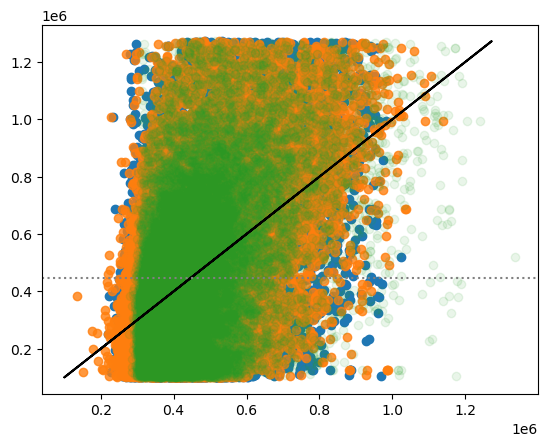

In [145]:
plt.scatter(pred_lr1, y_train, label='linear regression')
plt.scatter(pred_pr, y_train, label='ploynominal 2 deg', alpha=.8)
plt.scatter(pred_glm, y_train, label='glm', alpha=.1)
plt.plot(y_train, y_train, label='_nolegend_', color='black')

plt.axhline(baseline, ls=':', color='grey')
plt.annotate('Baseline', (0.2, 400_000))

plt.show()

#### Plotting the residuals

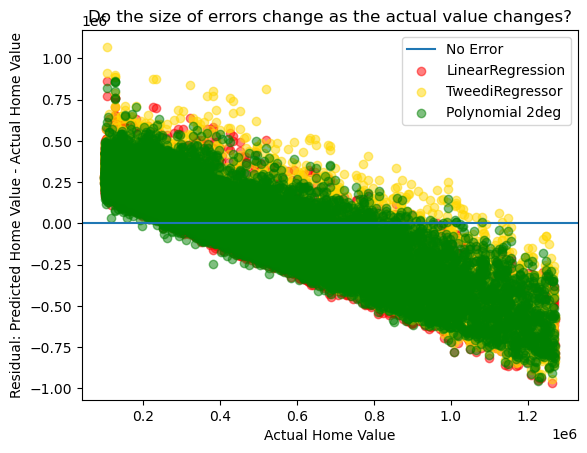

In [135]:
plt.axhline(label='No Error')

plt.scatter(y_train, pred_lr1 - y_train, alpha=.5, color='red', label='LinearRegression')
plt.scatter(y_train, pred_glm - y_train, alpha=.5, color='gold', label='TweediRegressor')
plt.scatter(y_train, pred_pr - y_train, alpha=.5, color='green', label='Polynomial 2deg')

plt.legend()
plt.title('Do the size of errors change as the actual value changes?')
plt.xlabel('Actual Home Value')
plt.ylabel('Residual: Predicted Home Value - Actual Home Value')

plt.show()

#### Histogram of actual and predicted values

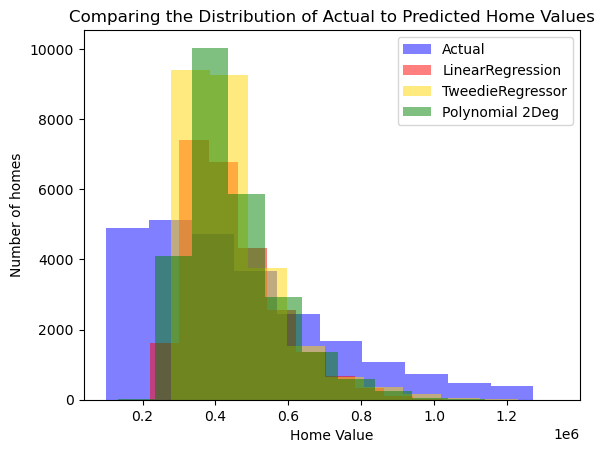

In [136]:
plt.hist(y_train, color='blue', alpha=.5, label='Actual')
plt.hist(pred_lr1, color='red', alpha=.5, label='LinearRegression')
plt.hist(pred_glm, color='gold', alpha=.5, label='TweedieRegressor')
plt.hist(pred_pr, color='green', alpha=.5, label='Polynomial 2Deg')

plt.xlabel("Home Value")
plt.ylabel("Number of homes")
plt.title("Comparing the Distribution of Actual to Predicted Home Values")
plt.legend()
plt.show()